In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import scikitplot.metrics as skplt
import joblib

In [3]:
train_df = pd.read_csv("../Data/ben_train_bow.csv")
test_df = pd.read_csv("../Data/ben_test_bow.csv")
X_train = train_df.drop(columns=["Y"])
Y_train = train_df["Y"]
X_test = test_df.drop(columns=["Y"])
Y_test = test_df["Y"]
X_train.head()

,chutiye,hain,kabir,kar,koi,kuch,kya,liye,log,mein,...,लन,लड़क,वह,सक,सम,समझ,समल,सर,हत,हम
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
scaler = MinMaxScaler()
scaler.fit(X_train)
scaler.partial_fit(X_test)
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

In [5]:
def run_the_mn_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'mnb1':
        
        mn_params = {
            'fit_prior': [True],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'mnb2':
        
         mn_params = {
            'fit_prior': [False],
            'alpha': [0, 0.5, 1]}
        
         M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train_text_df, y_train)
     
    print(f'Train score = {M.score(X_train_text_df, y_train)}')
    print(f'Test score = {M.score(X_test_text_df, y_test)}')
    
    predictions = M.predict(X_test_text_df)
    predictions_train = M.predict(X_train_text_df)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     #skplt.plot_roc_curve(predictions,y_test)
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.2s finished


Train score = 0.46204453441295545
Test score = 0.4466745375836285
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 1, 'fit_prior': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

           0       0.52      0.29      0.38       865
           1       0.43      0.72      0.54       834
           2       0.43      0.33      0.38       842

    accuracy                           0.45      2541
   macro avg       0.46      0.45      0.43      2541
weighted avg       0.46      0.45      0.43      2541



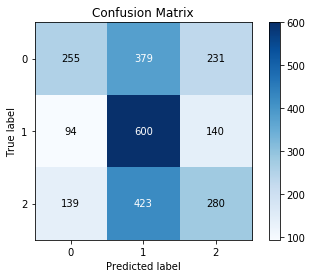

In [6]:
run_the_mn_models("mnb1", X_train_tf, X_test_tf, Y_train, Y_test)

In [7]:
def run_the_lr_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    
    if model == 'lr1':
        
        lr_1_params = {
            'penalty': ['l1'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],
            'random_state': [42],
            'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'lr2':
        
        lr_2_params = {
            'penalty': ['l2'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_2_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  57 out of  80 | elapsed:    2.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.0s finished


Train score = 0.47537112010796223
Test score = 0.45690672963400236
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'warm_start': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

           0       0.53      0.34      0.42       865
           1       0.43      0.73      0.54       834
           2       0.44      0.31      0.36       842

    accuracy                           0.46      2541
   macro avg       0.47      0.46      0.44      2541
weighted avg       0.47      0.46      0.44      2541



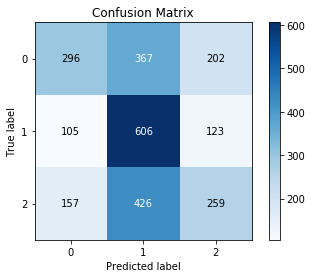

In [8]:
run_the_lr_models("lr2", X_train, X_test, Y_train, Y_test)

In [9]:
def run_the_sv_models(model, X_train, X_test, Y_tr, Y_te):   
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'sv1':
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000] }
        
        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'sv2':
        
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [0.01, 1, 10, 100],
            'C': [1, 10, 100, 1000] }

        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print("Invalid Model!")
        
    M.fit(X_train_text_df.values, y_train)
      
    #save in pickle file
    joblib.dump(M, "SVM_TFIDF.pkl")
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  8.6min finished


Train score = 0.6555330634278003
Test score = 0.5588351042896498
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       865
           1       0.46      0.71      0.56       834
           2       0.66      0.44      0.53       842

    accuracy                           0.56      2541
   macro avg       0.59      0.56      0.56      2541
weighted avg       0.59      0.56      0.56      2541



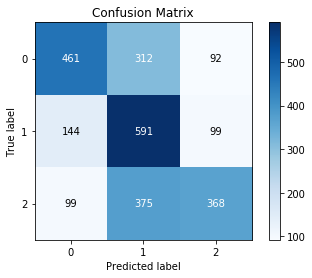

In [10]:
run_the_sv_models("sv2", X_train, X_test, Y_train, Y_test)